In [1]:
def install_reqs():
#This defines a function named install_reqs.
    
  !pip install pandas
#Installs the pandas library, used for reading and manipulating tabular data (like .csv, .tsv).
    
  !pip install "matplotlib>=3.4"
#Installs matplotlib version 3.4 or higher, used for plotting graphs and visualizations.
    
  !pip install numpy
#Installs numpy, a fundamental package for numerical computations and arrays.
    
  !pip install statsmodels
#Installs statsmodels, a library used for statistical tests (e.g., t-tests, Wilcoxon), regression, and model fitting.
    
  !pip install scipy
#Installs scipy, which contains scientific computing tools, including statistical and optimization functions.
    
install_reqs()
# to install all the above dependencies uncomment the above line.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab

In [4]:
from matplotlib import __version__ as matplotlibversion
if matplotlibversion < "3.4":
    print("Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays")

Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays


In [5]:
import os
os.system("compass --data expression.tsv \
          --model RECON2_mat --species mus_musculus --media default-media --lambda 0.25 \
          --and-function mean --output-dir extdata/Th17 --penalty-diffusion knn --num-neighbors 10 \
          --isoform-summing legacy --num-processes 50")

0

In [6]:
import os
print(os.getcwd())


C:\Users\HP\Human datasets


In [7]:
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col=0)

In [8]:
import pandas as pd

# Load reactions.tsv
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col=0)

# Extract cell IDs from the columns
cell_ids = reaction_penalties.columns

# Infer cell type from prefix
def infer_cell_type(cell_id):
    if cell_id.startswith("Tregs"):
        return "Tregs"
    elif cell_id.startswith("Tn"):
        return "Tn"
    elif cell_id.startswith("Th1"):
        return "Th1"
    elif cell_id.startswith("exTregs"):
        return "exTregs"
    else:
        return "Unknown"

cell_types = [infer_cell_type(cell) for cell in cell_ids]

# Create metadata DataFrame
cell_metadata = pd.DataFrame({
    "cell_id": cell_ids,
    "cell_type": cell_types
}).set_index("cell_id")

# Save to CSV
cell_metadata.to_csv("cell_metadata.csv")

print("✅ Created cell_metadata.csv with the following cell types:")
print(cell_metadata["cell_type"].value_counts())


✅ Created cell_metadata.csv with the following cell types:
cell_type
Tregs      14
Tn         14
Th1        14
exTregs    14
Name: count, dtype: int64


In [9]:
cell_metadata = pd.read_csv("cell_metadata.csv", sep=",")
cell_metadata.set_index("cell_id", inplace=True)

In [10]:
print(cell_metadata.columns.tolist())  
print(cell_metadata.head())

['cell_type']
               cell_type
cell_id                 
Tregs_Don7_Ln2     Tregs
Tregs_Don7_Ln1     Tregs
Tregs_Don6_Ln1     Tregs
Tregs_Don6_Ln2     Tregs
Tregs_Don5_Ln2     Tregs


In [11]:
Tregs_cells = cell_metadata.index[cell_metadata["cell_type"] == "Tregs"]
Tn_cells = cell_metadata.index[cell_metadata["cell_type"] == "Tn"]
Th1_cells = cell_metadata.index[cell_metadata["cell_type"] == "Th1"]
exTregs_cells = cell_metadata.index[cell_metadata["cell_type"] == "exTregs"]

In [12]:
print(cell_metadata.columns.tolist())


['cell_type']


In [13]:
print(cell_metadata.head())
print(cell_metadata.columns.tolist())

               cell_type
cell_id                 
Tregs_Don7_Ln2     Tregs
Tregs_Don7_Ln1     Tregs
Tregs_Don6_Ln1     Tregs
Tregs_Don6_Ln2     Tregs
Tregs_Don5_Ln2     Tregs
['cell_type']


In [14]:
reaction_metadata = pd.read_csv("reaction_metadata.csv", index_col = 0) 

In [15]:
reaction_metadata.loc[['r0281']]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r0281,Putrescine:oxygen oxidoreductase (deaminating)...,1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putr...,AOC1,Methionine and cysteine metabolism,1.4.3.6,0.0


In [16]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [17]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

In [18]:
common_cells = list(set(reaction_consistencies.columns).intersection(set(cell_metadata.index)))
reaction_consistencies = reaction_consistencies[common_cells]

In [21]:
wilcox_results = wilcoxon_test(reaction_consistencies, Tn_cells, exTregs_cells)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [24]:
print(reaction_consistencies.columns.tolist()[:10])

['Th1_Don6_Ln2', 'Tn_Don1_Ln1', 'exTregs_Don6_Ln1', 'Th1_Don7_Ln1', 'Tregs_Don4_Ln1', 'Tn_Don7_Ln2', 'exTregs_Don6_Ln2', 'Tregs_Don3_Ln2', 'Tregs_Don5_Ln1', 'Tn_Don3_Ln1']


In [25]:
print(Tregs_cells[:10]) 

Index(['Tregs_Don7_Ln2', 'Tregs_Don7_Ln1', 'Tregs_Don6_Ln1', 'Tregs_Don6_Ln2',
       'Tregs_Don5_Ln2', 'Tregs_Don5_Ln1', 'Tregs_Don4_Ln2', 'Tregs_Don4_Ln1',
       'Tregs_Don3_Ln2', 'Tregs_Don3_Ln1'],
      dtype='object', name='cell_id')


In [26]:
# Run the test
wilcox_results = wilcoxon_test(reaction_consistencies, Tn_cells, exTregs_cells)

# Annotate metadata keys
wilcox_results['metadata_r_id'] = ""

for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print(f"Should not occur → {r}")

In [41]:
# Run the test
wilcox_results = wilcoxon_test(reaction_consistencies, Tn_cells, exTregs_cells)

# Annotate metadata keys
wilcox_results['metadata_r_id'] = ""

for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print(f"Should not occur → {r}")


In [42]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [43]:
wilcox_results.loc[['r0281_pos']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_pos,196.0,0.000007,3.476863,0.000015,r0281


In [44]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

In [48]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    
    # Visual markers and title
    axs.set_xlim(-8, 12)
    axs.set_ylim(0, 8)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})

    # Arrows for sample identity
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08), 
                 arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Tn_cells', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
                 arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('exTregs_cells', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)

    # Dynamic annotation loop with variable offsets and labels
    for i, r in enumerate(data.index):
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])

            dx = 30 if x >= 0 else -120  # horizontal offset
            dy = (i % 6) * 12 - 30       # vertical offset varies to reduce stacking

            axs.annotate(
                labeled_reactions[r],
                (x, y),
                xytext=(dx, dy),
                textcoords='offset pixels',
                arrowprops=dict(arrowstyle="-", shrinkA=6, shrinkB=4),
                fontsize=10,
                zorder=5,  # make sure text is on top
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
            )


In [49]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
             W[W['subsystem'] == "Citric acid cycle"],
            W[W['subsystem'].isin(amino_acid_metab)],
           W[W['subsystem'] == "Fatty acid oxidation"]])

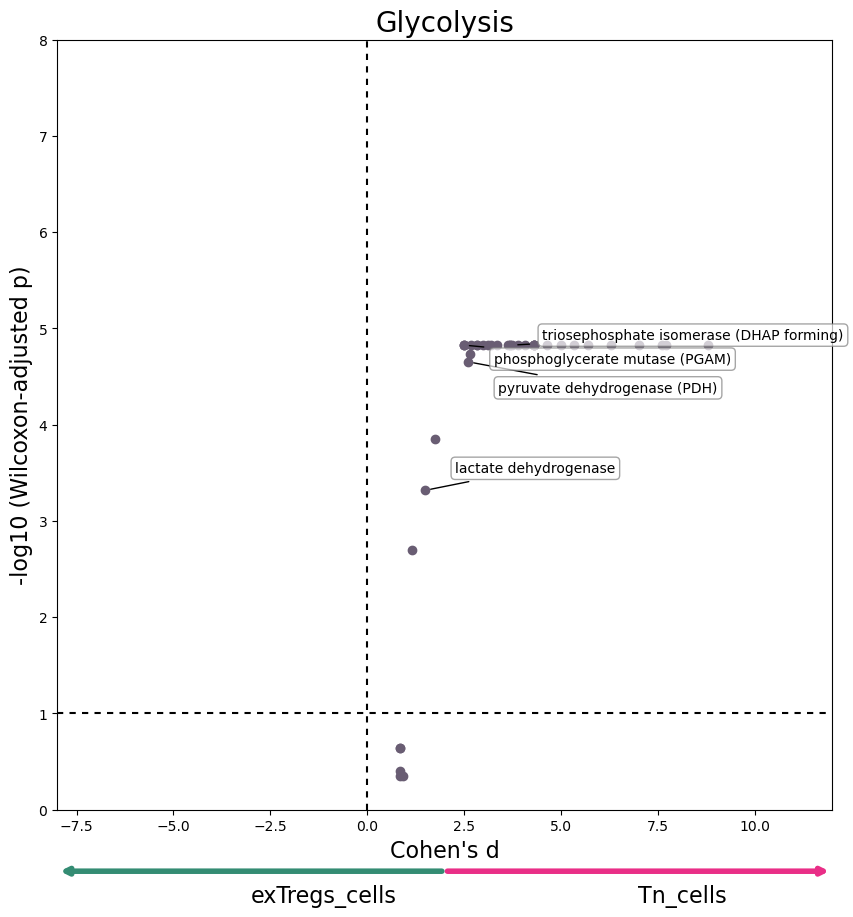

In [50]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

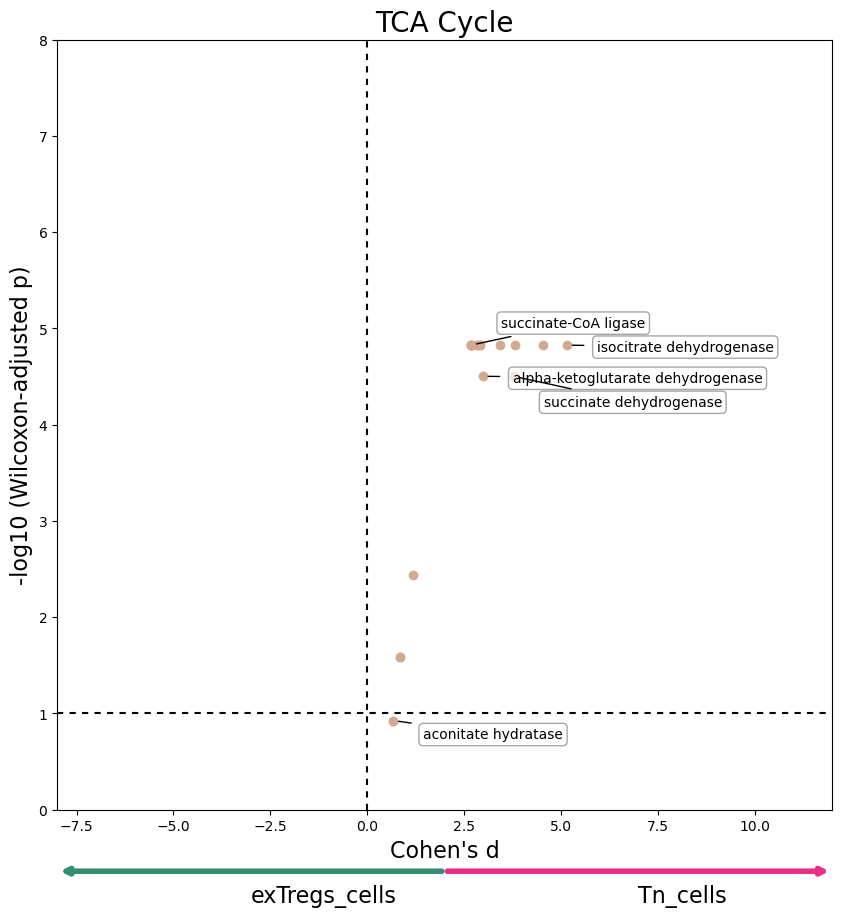

In [51]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

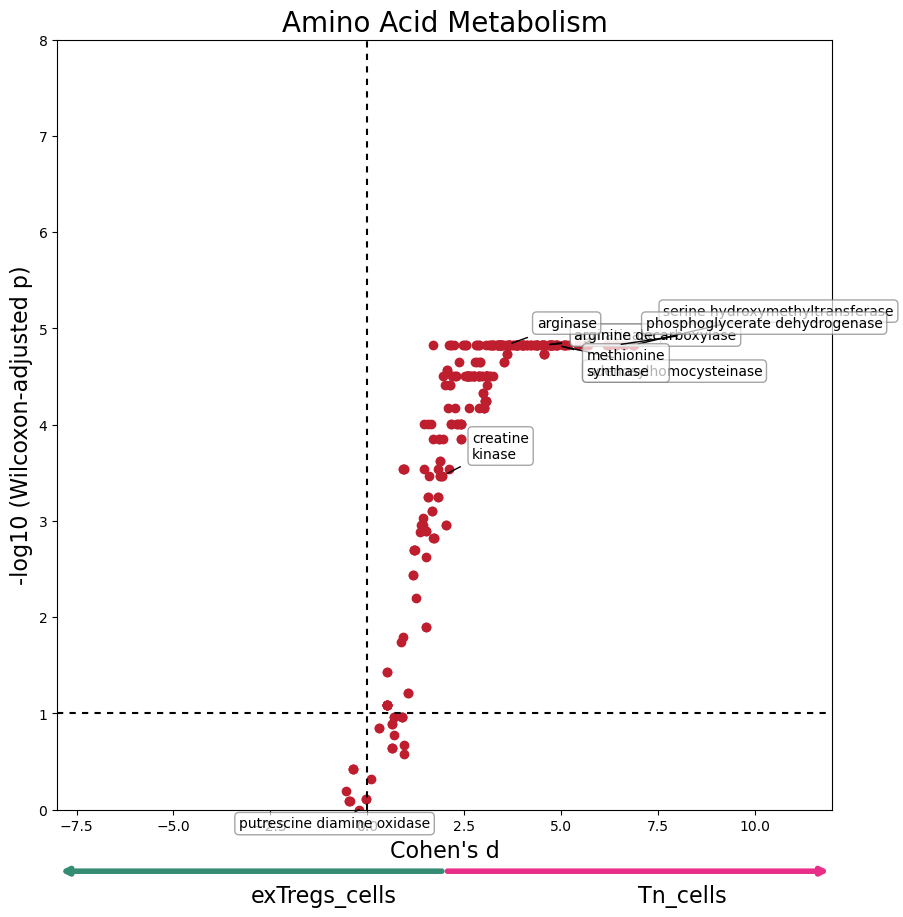

In [52]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

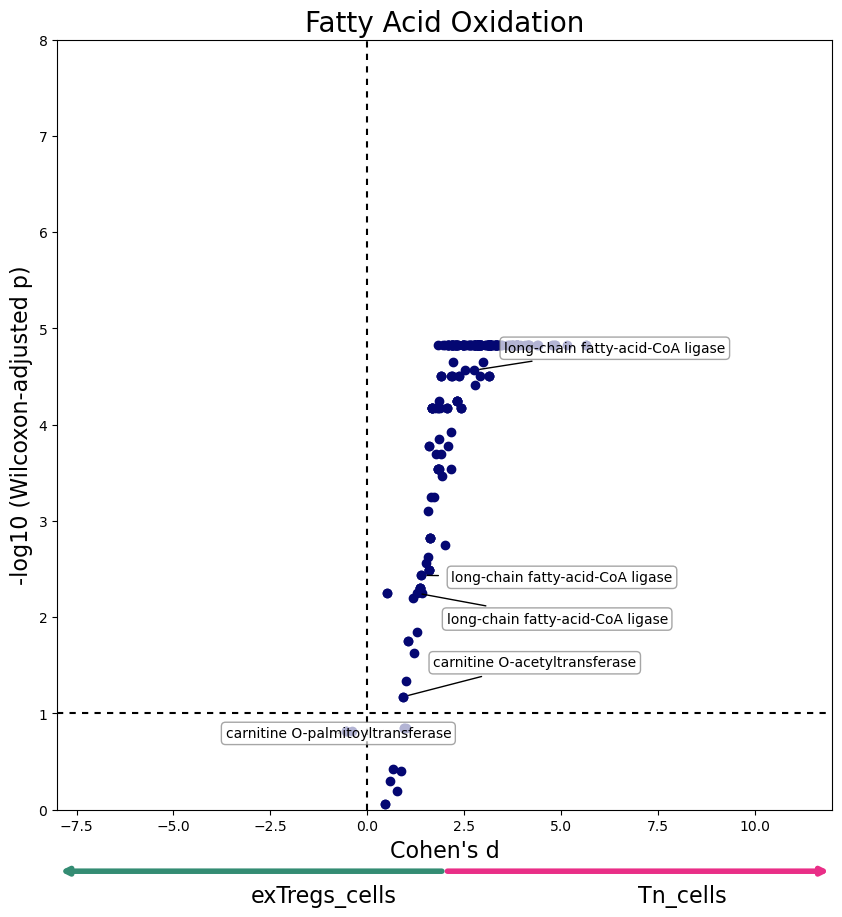

In [53]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

In [54]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 1.0, 'Pathway-Level Differential Activity')

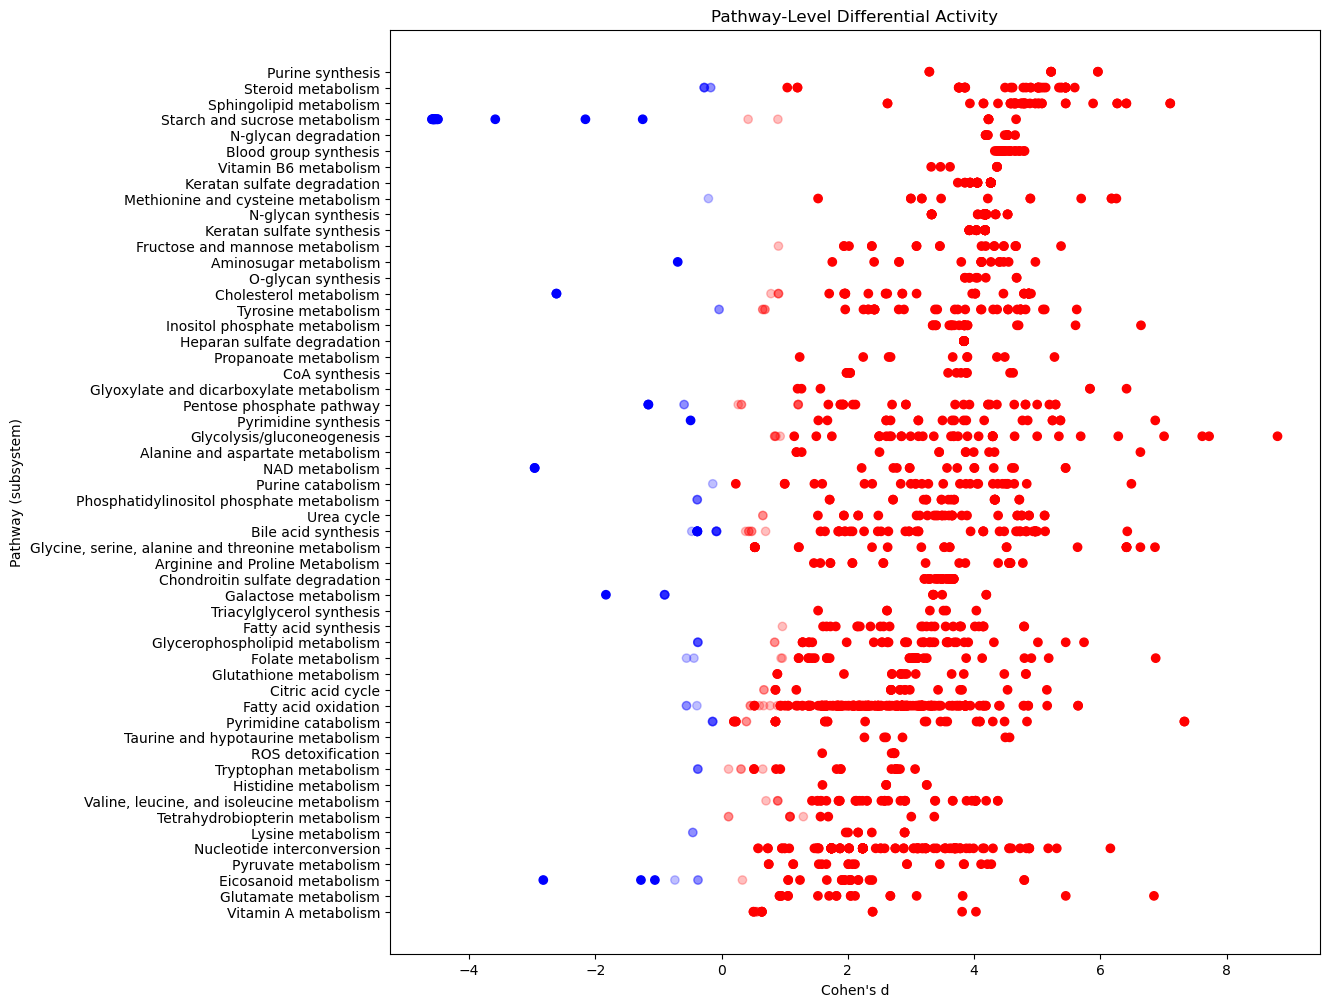

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
axs = plt.gca()

d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()

d_sorted = d.sort_values()

axs.scatter(d_sorted, d_sorted.index, alpha=0)

color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)

axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)

axs.set_xlabel("Cohen's d")
axs.set_ylabel("Pathway (subsystem)")
axs.set_title("Pathway-Level Differential Activity")


In [56]:
reaction_penalties = pd.read_csv("reactions.tsv", sep="\t", index_col = 0)
reaction_penalties[reaction_penalties <= 1e-4] = 0
reaction_penalties = reaction_penalties[np.all(reaction_penalties != 0, axis=1)]

In [57]:
reaction_penalties = reaction_penalties[reaction_penalties.max(axis=1) - reaction_penalties.min(axis=1) != 0]

In [58]:
meta_rxns_map = get_metareactions(reaction_penalties)
meta_rxns = reaction_penalties.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reaction_penalties.index)).groupby("meta_rxn_id").mean()

In [59]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [61]:
treg_cells = cell_metadata.index[cell_metadata["cell_type"] == "Tn"]
tcon_cells = cell_metadata.index[cell_metadata["cell_type"] == "exTregs"]

wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, Tregs_cells, exTregs_cells)

In [62]:
wilcox_meta_rxn_results.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval
meta_rxn_id,,,,
1,153.0,0.012275,0.965008,0.014344


In [63]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reaction_penalties.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [64]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ""
for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [65]:
wilcox_meta_rxn_expanded.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,194.0,0.000011,3.603294,0.000019,10FTHF5GLUtl


In [66]:
outputs = {
    "wilcox_results.csv": wilcox_results,
    "reaction_consistencies.csv": reaction_consistencies,
    "reaction_metadata.csv": reaction_metadata,
    "wilcox_meta_rxn_results.csv": wilcox_meta_rxn_results,
    "wilcox_meta_rxn_expanded.csv": wilcox_meta_rxn_expanded,
    "final_stats_with_metadata.csv": W,
}

for name, df in outputs.items():
    df.to_csv(name)

In [93]:
import zipfile

with zipfile.ZipFile("Tn vs exTregs.zip", "w") as zipf:
    for filename in outputs:
        zipf.write(filename)


In [95]:
from IPython.display import FileLink
FileLink("Tn vs exTregs.zip")

C:\Users\HP\Human datasets\Tn vs exTregs.zip